# Part 14

## # Dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv('../datasets/petr4_treinamento.csv')
df_train.shape, df_train.columns

((1245, 7),
 Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object'))

In [3]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [4]:
def _isnull(df):
    for c in df.columns:
        cnt = df[pd.isnull(df[c])].shape[0]
        if cnt != 0:
            print(f'# {c}: {cnt} rows')

In [5]:
_isnull(df_train)

# Open: 3 rows
# High: 3 rows
# Low: 3 rows
# Close: 3 rows
# Adj Close: 3 rows
# Volume: 3 rows


In [6]:
df_train.dropna(axis=0, inplace=True)
df_train.reset_index(inplace=True, drop=True)
df_train.shape

(1242, 7)

In [7]:
df_train.shape

(1242, 7)

DAYS BEFORE = 90

In [8]:
def daysbefore(df, days_before, col):
    feature = []
    target = []
    for i in range(days_before, df.shape[0]):
        slice_start = i - days_before
        slice_stop = i
        feature.append(df[col].iloc[slice_start:slice_stop].values)
        target.append(df[col].iloc[i])
    return np.array(feature), np.array(target)

In [9]:
x, y = daysbefore(df_train, 90, 'Open')

In [10]:
df_open_train = pd.DataFrame(data=x)
df_open_train['target'] = y
df_open_train.shape

(1152, 91)

In [11]:
df_open_train.tail()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,target
1147,13.64,13.70,13.78,13.78,13.87,13.93,13.76,13.79,13.53,13.85,...,15.36,15.65,15.10,15.05,15.16,15.18,15.21,15.31,15.75,15.75
1148,13.70,13.78,13.78,13.87,13.93,13.76,13.79,13.53,13.85,13.96,...,15.65,15.10,15.05,15.16,15.18,15.21,15.31,15.75,15.75,15.75
1149,13.78,13.78,13.87,13.93,13.76,13.79,13.53,13.85,13.96,14.57,...,15.10,15.05,15.16,15.18,15.21,15.31,15.75,15.75,15.75,15.99
1150,13.78,13.87,13.93,13.76,13.79,13.53,13.85,13.96,14.57,14.65,...,15.05,15.16,15.18,15.21,15.31,15.75,15.75,15.75,15.99,16.10
1151,13.87,13.93,13.76,13.79,13.53,13.85,13.96,14.57,14.65,15.02,...,15.16,15.18,15.21,15.31,15.75,15.75,15.75,15.99,16.10,16.10


In [12]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))
x.shape, y.shape

((1152, 90, 1), (1152,))

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=42)

f'{xtrain.shape}, {ytrain.shape}, {xtest.shape}, {ytest.shape}'

'(864, 90, 1), (864,), (288, 90, 1), (288,)'

## # Model

In [15]:
from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dropout, Dense, LSTM, RNN

In [16]:
def model():
    clear_session()
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True,
                   input_shape=(xtrain.shape[1], xtrain.shape[2])))
    model.add(Dropout(rate=0.5))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(rate=0.5))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(rate=0.5))
    model.add(LSTM(units=50))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer='rmsprop', loss='mse', metrics='mae')
    print(model.summary())
    return model

In [17]:
clf = model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 90, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [18]:
clf.fit(x=xtrain, y=ytrain, validation_data=(xtest, ytest), epochs=200)

Epoch 1/200
27/27 [==============================] - 3s 115ms/step - loss: 86.9676 - mae: 8.1310 - val_loss: 45.1387 - val_mae: 5.5962
Epoch 2/200
27/27 [==============================] - 2s 62ms/step - loss: 36.7297 - mae: 5.1121 - val_loss: 29.2168 - val_mae: 4.4439
Epoch 3/200
27/27 [==============================] - 2s 65ms/step - loss: 25.2547 - mae: 4.0573 - val_loss: 19.8961 - val_mae: 3.5661
Epoch 4/200
27/27 [==============================] - 2s 62ms/step - loss: 17.6218 - mae: 3.2879 - val_loss: 13.2295 - val_mae: 2.7902
Epoch 5/200
27/27 [==============================] - 2s 61ms/step - loss: 12.4558 - mae: 2.7764 - val_loss: 9.2370 - val_mae: 2.2387
Epoch 6/200
27/27 [==============================] - 2s 63ms/step - loss: 9.7743 - mae: 2.3809 - val_loss: 6.4093 - val_mae: 1.8267
Epoch 7/200
27/27 [==============================] - 2s 62ms/step - loss: 9.8208 - mae: 2.4329 - val_loss: 5.3737 - val_mae: 1.7237
Epoch 8/200
27/27 [==============================] - 2s 62ms/step 

27/27 [==============================] - 2s 64ms/step - loss: 4.3210 - mae: 1.5995 - val_loss: 0.4099 - val_mae: 0.4302
Epoch 124/200
27/27 [==============================] - 2s 61ms/step - loss: 4.0585 - mae: 1.5572 - val_loss: 0.5181 - val_mae: 0.5128
Epoch 125/200
27/27 [==============================] - 2s 63ms/step - loss: 4.0963 - mae: 1.5457 - val_loss: 0.6668 - val_mae: 0.6642
Epoch 126/200
27/27 [==============================] - 2s 65ms/step - loss: 4.0313 - mae: 1.5559 - val_loss: 0.4050 - val_mae: 0.4525
Epoch 127/200
27/27 [==============================] - 2s 63ms/step - loss: 3.8915 - mae: 1.5148 - val_loss: 0.6047 - val_mae: 0.5890
Epoch 128/200
27/27 [==============================] - 2s 63ms/step - loss: 4.0209 - mae: 1.5669 - val_loss: 0.9101 - val_mae: 0.7835
Epoch 129/200
27/27 [==============================] - 2s 61ms/step - loss: 3.6234 - mae: 1.4947 - val_loss: 0.4444 - val_mae: 0.4616
Epoch 130/200
27/27 [==============================] - 2s 67ms/step - loss: 

## # Evaluation

In [19]:
pred = clf.predict(xtest)

In [20]:
ytest.shape, pred.shape

((288,), (288, 1))

In [21]:
ytest.mean() - pred.mean()

-0.14881262655300453

In [22]:
ytest.std() - pred.std()

0.017990239404587882

### ## Test data

In [23]:
df_test = pd.read_csv('../datasets/petr4_teste.csv')
df_test.shape, df_test.columns

((22, 7),
 Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object'))

In [24]:
df_test.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
17,2018-01-25,19.340000,19.340000,19.340000,19.340000,19.301397,0
18,2018-01-26,19.620001,19.980000,19.100000,19.930000,19.890221,81989500
19,2018-01-29,19.670000,20.049999,19.570000,19.850000,19.810381,55726200
20,2018-01-30,19.770000,19.770000,19.360001,19.490000,19.451097,46203000
21,2018-01-31,19.740000,19.930000,19.680000,19.700001,19.660681,41576600


In [25]:
df_complete = pd.concat(objs=[df_train, df_test], axis=0)
df_complete.reset_index(inplace=True, drop=True)
df_complete.shape

(1264, 7)

In [26]:
df_complete.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1259,2018-01-25,19.340000,19.340000,19.340000,19.340000,19.301397,0.0
1260,2018-01-26,19.620001,19.980000,19.100000,19.930000,19.890221,81989500.0
1261,2018-01-29,19.670000,20.049999,19.570000,19.850000,19.810381,55726200.0
1262,2018-01-30,19.770000,19.770000,19.360001,19.490000,19.451097,46203000.0
1263,2018-01-31,19.740000,19.930000,19.680000,19.700001,19.660681,41576600.0


In [162]:
x, y = daysbefore(df_complete, 90, 'Open')

In [28]:
x.shape, y.shape

((1174, 90), (1174,))

In [29]:
df_open_test = pd.DataFrame(data=x)
df_open_test['target'] = y
df_open_test.shape

(1174, 91)

In [30]:
df_open_test.tail()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,target
1169,15.25,15.85,15.60,15.79,15.86,15.70,15.37,15.50,15.19,15.60,...,17.040001,17.320000,17.350000,17.920000,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000
1170,15.85,15.60,15.79,15.86,15.70,15.37,15.50,15.19,15.60,15.90,...,17.320000,17.350000,17.920000,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000,19.620001
1171,15.60,15.79,15.86,15.70,15.37,15.50,15.19,15.60,15.90,15.88,...,17.350000,17.920000,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000,19.620001,19.670000
1172,15.79,15.86,15.70,15.37,15.50,15.19,15.60,15.90,15.88,15.66,...,17.920000,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000,19.620001,19.670000,19.770000
1173,15.86,15.70,15.37,15.50,15.19,15.60,15.90,15.88,15.66,15.61,...,18.350000,18.309999,18.260000,18.400000,18.420000,19.340000,19.620001,19.670000,19.770000,19.740000


In [31]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))
x.shape, y.shape

((1174, 90, 1), (1174,))

In [32]:
pred = clf.predict(x)

In [33]:
pred.shape, y.shape

((1174, 1), (1174,))

In [34]:
y.mean() - pred.mean()

-0.1250889455340758

In [35]:
y.std() - pred.std()

0.02129808379464926

In [72]:
import matplotlib.pyplot as plt

%matplotlib inline

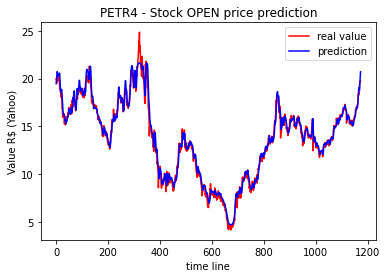

In [143]:
plt.plot(y, color='red', label='real value')
plt.plot(pred, color='blue', label='prediction')
plt.title('PETR4 - Stock OPEN price prediction')
plt.xlabel('time line')
plt.ylabel('Value R$ (Yahoo)')
plt.legend()
plt.show()

## ## Multiple inputs & Callbacks

In [44]:
df_train.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [164]:
x_m, _ = daysbefore(df_train, 90, ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
y_m = df_train['Open'][90:]
x_m.shape, y_m.shape

((1152, 90, 6), (1152,))

In [165]:
xtrain_m, xtest_m, ytrain_m, ytest_m = train_test_split(x_m, y_m,
                                                        test_size=0.25, random_state=42)

xtrain_m.shape, ytrain_m.shape, xtest_m.shape, ytest_m.shape

((864, 90, 6), (864,), (288, 90, 6), (288,))

In [97]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [98]:
es = EarlyStopping(monitor='loss', min_delta=1e-20, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1)
mcp = ModelCheckpoint(monitor='loss', filepath='sess_14-weights.h5.',
                      save_best_only=True, verbose=1)

In [177]:
def model_m():
    clear_session()
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True,
                   input_shape=(xtrain_m.shape[1], xtrain_m.shape[2])))
    model.add(Dropout(rate=0.5))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(rate=0.5))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=10, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer='rmsprop', loss='mse', metrics='mae')
    print(model.summary())
    return model

In [178]:
clf_m = model_m()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 100)           42800     
_________________________________________________________________
dropout (Dropout)            (None, 90, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
dense (Dense)                (None, 90, 10)            5

In [ ]:
# clf_m.fit(x=xtrain_m, y=xtrain_m, validation_data=(xtest_m, ytest_m), epochs=200,
#          callbacks=[es, rlr, mcp])
clf_m.fit(x=xtrain_m, y=ytrain_m, validation_data=(xtest_m, ytest_m), epochs=200)

Epoch 1/200
27/27 [==============================] - 2s 79ms/step - loss: 85.9691 - mae: 7.9162 - val_loss: 34.7414 - val_mae: 4.8563
Epoch 2/200
27/27 [==============================] - 1s 49ms/step - loss: 27.5263 - mae: 4.2819 - val_loss: 20.4825 - val_mae: 3.7337
Epoch 3/200
27/27 [==============================] - 1s 47ms/step - loss: 22.5077 - mae: 3.8281 - val_loss: 19.4193 - val_mae: 3.6608
Epoch 4/200
27/27 [==============================] - 1s 46ms/step - loss: 21.5327 - mae: 3.7612 - val_loss: 18.9057 - val_mae: 3.6358
Epoch 5/200
27/27 [==============================] - 1s 46ms/step - loss: 20.8943 - mae: 3.7105 - val_loss: 18.8399 - val_mae: 3.6470
Epoch 6/200
27/27 [==============================] - 1s 46ms/step - loss: 20.6844 - mae: 3.6982 - val_loss: 18.3971 - val_mae: 3.5922
Epoch 7/200
27/27 [==============================] - 1s 46ms/step - loss: 20.3846 - mae: 3.6764 - val_loss: 18.5222 - val_mae: 3.6157
Epoch 8/200
27/27 [==============================] - 1s 46ms/s

Epoch 62/200
27/27 [==============================] - 1s 47ms/step - loss: 18.5497 - mae: 3.5001 - val_loss: 18.4418 - val_mae: 3.5816
Epoch 63/200
27/27 [==============================] - 1s 47ms/step - loss: 18.7606 - mae: 3.5289 - val_loss: 17.9628 - val_mae: 3.5125
Epoch 64/200
27/27 [==============================] - 1s 49ms/step - loss: 18.5715 - mae: 3.5085 - val_loss: 18.1901 - val_mae: 3.5505
Epoch 65/200
23/27 [========================>.....] - ETA: 0s - loss: 18.2160 - mae: 3.4563

### ## Evaluation

In [144]:
pred_m = clf_m.predict(xtest_m)

In [145]:
pred_m.shape, ytest_m.shape

((288, 1), (288,))

In [146]:
ytest_m.mean() - pred_m.mean()

0.3907925141330306

In [147]:
ytest_m.std() - pred_m.std()

3.685787297187133

### ## Test data

In [168]:
x_m, _ = daysbefore(df_complete, 90, ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
# y_m = df_complete['Open'][90:]
x_m.shape, y.shape

((1174, 90, 6), (1174,))

In [169]:
pred_m = clf_m.predict(x_m) 

In [170]:
pred_m.shape, y_m.shape, 

((1174, 1), (1152,))

In [171]:
y_m.mean() - pred_m.mean()

4.701306913547093

In [172]:
y_m.std() - pred_m.std()

4.078585924643513

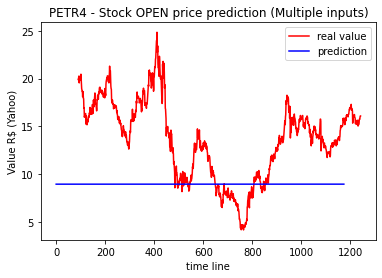

In [173]:
plt.plot(y_m, color='red', label='real value')
plt.plot(pred_m, color='blue', label='prediction')
plt.title('PETR4 - Stock OPEN price prediction (Multiple inputs)')
plt.xlabel('time line')
plt.ylabel('Value R$ (Yahoo)')
plt.legend()
plt.show()

### ## All results

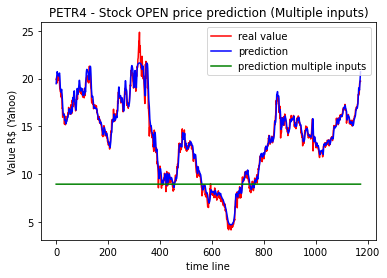

In [175]:
plt.plot(y, color='red', label='real value')
plt.plot(pred, color='blue', label='prediction')
plt.plot(pred_m, color='green', label='prediction multiple inputs')
plt.title('PETR4 - Stock OPEN price prediction (Multiple inputs)')
plt.xlabel('time line')
plt.ylabel('Value R$ (Yahoo)')
plt.legend()
plt.show()